In [1]:
''' Load dependencies '''

### Elementary libraries
import pandas as pd
import numpy as np


### Graphic libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns


### Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

### Some Scikit-learn utils
from sklearn.cluster import BisectingKMeans, KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


### Models
from xgboost import XGBClassifier, plot_importance
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet



### Some cosmetics and makeup add-ons
import warnings
# prevents numpy and pandas scientific/exponential notation on print, default is False
# force-suppressing the scientific notation, it is rounded and justified
#np.set_printoptions(suppress=True, formatter={'float_kind': '{:0.4f}'.format})
pd.options.display.float_format = '{:.4f}'.format
# ignoring warnings, suppressing/preventing/hushing up all warnings
warnings.filterwarnings(action='ignore')
sns.set_style("whitegrid")

colors = ['blue', 'orange', 'green', 'red']
pal = sns.color_palette(colors, 4)


In [2]:

''' 
 
this is an user-defined function: creating our own functions based on our requirements especially to reduce the coding
  
*args in Python (Non-Keyword Arguments): arbitrary keyword argument, *args can pass a variable number of arguments     
**kwargs in Python (Keyword Arguments): arbitrary keyword argument, **kargs can pass a variable number of arguments 
 
'''

def take_desired_interval(data: pd.DataFrame, start_date: pd.to_datetime, end_date: pd.to_datetime) -> pd.DataFrame:
    
    #print(f'\n')
    """ Filtered set of data based on the given period and performing custom feature scaling as well: """

    # body of the function
    df = pd.pivot_table( data.loc[(data['DateTime'] >= start_date) & (data['DateTime'] <= end_date)],
                         values='Amount',            # ['A', 'B']      
                         index='Client', 
                         columns='Top Category', 
                         aggfunc={'Amount': 'sum'},  # {'A':'sum', 'B':'mean'}
                         fill_value=0, 
                         margins=True, 
                         dropna=True, 
                         margins_name='total',  # All
                         observed=False, 
                         sort=True
                       )

    ''' 
    performing custom feature scaling
    '''

    for row in df.itertuples():
        df.at[row.Index, 'money'] = df.loc[row.Index, 'money'] / (df.loc[row.Index, 'total'])
        df.at[row.Index, 'self_realization'] = df.loc[row.Index, 'self_realization'] / (df.loc[row.Index, 'total'])
        df.at[row.Index, 'socialization'] = df.loc[row.Index, 'socialization'] / (df.loc[row.Index, 'total'])
        df.at[row.Index, 'survival'] = df.loc[row.Index, 'survival'] / (df.loc[row.Index, 'total'])


    ''' it means all rows except last one and all columns except the last column '''
    df = df.iloc[:-1, :-1]                

    return df

In [3]:
''' 
reading whole dataset from the given file and loading those data and save them in a DataFrame, named df_data

'''
df_data = pd.read_csv("/Users/USER/Desktop/2025 ITMO THESIS/transact_18_22.csv")
working_df = df_data.copy()   # make for security a copy of the original dataframe before further processing 

categories=['food', 'outfit', 'dwelling', 'health', 'beauty', 'remote', 'travel','money', 'kids', 'nonfood', 'telecom', 'fun', 'charity', 'misc']
working_df = working_df.loc[(working_df['group'].isin(categories))]


print(f'\n')
print("Number of rows before removing transactions less than 500 and duplications:", len(working_df))
working_df = working_df.loc[(working_df['amt'] > 500)]

print(f'\n')
print("Number of rows after removing transactions less than 500 and before removing duplications:", len(working_df))
working_df.drop_duplicates(keep=False, inplace=True)

print(f'\n')
print("Number of rows after removing transactions less than 500 and removing duplications:", len(working_df))


working_df.rename(columns = {'client':'Client', 'card':'Card', 'amt':'Amount', 'mcc':'MCC', 'group':'Category', 'value':'Top Category'}, inplace = True)

working_df['DateTime'] = pd.to_datetime(working_df['date'])

junky_fields = ['date']

working_df.drop(junky_fields, axis=1, inplace=True)

#working_df['Amount_L10'] = np.log10(working_df['Amount'])   # np.log10(working_df['Amount']).round().astype(int), np.log10(working_df['Amount']).astype(float)

scaler = MinMaxScaler(feature_range=(-1, 1))
working_df['Amount_MinMax'] = scaler.fit_transform(working_df[['Amount']])

print(f'\n')
working_df



Number of rows before removing transactions less than 500 and duplications: 19026862


Number of rows after removing transactions less than 500 and before removing duplications: 8316331


Number of rows after removing transactions less than 500 and removing duplications: 8059496




,Client,Card,Amount,MCC,Category,Top Category,DateTime,Amount_MinMax
0,390989,3048567,878.0000,5814,food,survival,2018-01-01,-1.0000
3,475694,2884069,2564.0000,5941,fun,self_realization,2018-01-01,-0.9998
5,2406107,3465449,909.3800,5411,food,survival,2018-01-01,-1.0000
7,2714314,3732417,1071.0000,5411,food,survival,2018-01-01,-0.9999
10,1356203,3823801,500.5000,5541,travel,socialization,2018-01-01,-1.0000
...,...,...,...,...,...,...,...,...
19262659,2936262,6378152,4000.0000,6011,money,money,2022-08-15,-0.9996
19262661,1529535,4825266,4766.7200,6536,money,money,2022-08-15,-0.9995
19262664,266552,6271909,3900.0000,6011,money,money,2022-08-15,-0.9996
19262666,2643664,6889520,5000.0000,6011,money,money,2022-08-15,-0.9995


## **3. Calculating between March 2019 - March 2020 and March 2021 - March 2022** 

## 3.1 Calculating the amount difference between March 2019 and March 2020

In [4]:
wdf_032019_pivoted = take_desired_interval(working_df, '2019-03-15', '2019-03-31')

wdf_032020_pivoted = take_desired_interval(working_df, '2020-03-15', '2020-03-31')

wdf_032020_032019 = wdf_032020_pivoted.sub(wdf_032019_pivoted, axis='columns', level = None, fill_value = 0) 

wdf_032020_032019

Top Category,money,self_realization,socialization,survival
Client,,,,
224,0.0000,0.0000,-0.3669,0.3669
1108,-0.2815,-0.0803,0.0000,0.3618
1117,-0.2568,-0.1458,-0.1180,0.5207
1197,0.7031,0.0000,0.0000,-0.7031
1223,0.1555,0.0000,-0.0310,-0.1245
...,...,...,...,...
3560436,0.6446,0.2149,0.0376,0.1029
3561841,0.4255,0.0980,0.0543,-0.5779
3561945,0.0000,0.0000,-0.1501,0.1501


## 3.2 Calculating the amount difference between March 2022 and March 2021

In [5]:
wdf_032021_pivoted = take_desired_interval(working_df, '2021-03-15', '2021-03-31')

wdf_032022_pivoted = take_desired_interval(working_df, '2022-03-15', '2022-03-31')

wdf_032022_032021 = wdf_032022_pivoted.sub(wdf_032021_pivoted, axis='columns', level = None, fill_value = 0) 

wdf_032022_032021

Top Category,money,self_realization,socialization,survival
Client,,,,
224,0.0000,0.0000,0.1498,-0.1498
1108,-0.6039,0.1850,0.0000,0.4189
1117,-0.1964,-0.1015,-0.1100,-0.5921
1197,0.0000,-0.7738,-0.0447,0.8185
1223,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...
3560436,-0.8187,0.7677,0.0000,0.0509
3561841,0.1315,-0.1917,-0.1897,0.2499
3561945,-0.9318,0.0000,0.0000,0.9318


In [6]:
''' finding unique clients in both dataframes '''

unique_clients = wdf_032020_032019.index.intersection(wdf_032022_032021.index)

wdf_032020_032019 = wdf_032020_032019[wdf_032020_032019.index.isin(unique_clients)]

wdf_032022_032021 = wdf_032022_032021[wdf_032022_032021.index.isin(unique_clients)]

## 3.2 Segmentation process

In [7]:

model_KMeans = KMeans(n_clusters = 4, init = 'k-means++', n_init = 100, max_iter = 300, tol = 0.0001, random_state = 40, copy_x = True, algorithm = 'elkan')

''' fitting the model to our dataset '''    
model_KMeans.fit(wdf_032020_032019[['survival', 'socialization', 'self_realization', 'money']])

''' assigning new column to the wdf_032020_032019 dataframe and inserting the labels_ (= already predicted values) '''  
wdf_032020_032019['clusters_2020_2019'] = model_KMeans.labels_


wdf_032020_032019

Top Category,money,self_realization,socialization,survival,clusters_2020_2019
Client,,,,,
224,0.0000,0.0000,-0.3669,0.3669,3
1108,-0.2815,-0.0803,0.0000,0.3618,3
1117,-0.2568,-0.1458,-0.1180,0.5207,3
1197,0.7031,0.0000,0.0000,-0.7031,2
1223,0.1555,0.0000,-0.0310,-0.1245,0
...,...,...,...,...,...
3560436,0.6446,0.2149,0.0376,0.1029,2
3561841,0.4255,0.0980,0.0543,-0.5779,2
3561945,0.0000,0.0000,-0.1501,0.1501,3


In [8]:

''' pd.DataFrame creates index by default '''

temp_2020_2019 = pd.DataFrame(wdf_032020_032019['clusters_2020_2019'].value_counts())

''' removing index from the temp_2020_2019 dataframe and renaming the colunms then sorting the dataframe '''

temp_2020_2019 = temp_2020_2019.reset_index() 

temp_2020_2019.rename(columns = {'index':'clusters_2020_2019', 'clusters_2020_2019':'number of clients in each cluster'}, inplace = True)

temp_2020_2019 = temp_2020_2019.sort_values(by = 'clusters_2020_2019', ascending = True)

temp_2020_2019


,clusters_2020_2019,number of clients in each cluster
0,0,4179
2,1,1780
3,2,1747
1,3,2235


## **4. Calculating between March 2021 and March 2022**


## 4.1 Segmentation process



In [9]:
''' predicting after fitting has been done'''  
predicted_values = model_KMeans.predict(wdf_032022_032021[['survival', 'socialization', 'self_realization', 'money']])

''' assigning new column to the wdf_032022_032021 dataframe and inserting the predicted values''' 
wdf_032022_032021['clusters_2022_2021'] = predicted_values


wdf_032022_032021

Top Category,money,self_realization,socialization,survival,clusters_2022_2021
Client,,,,,
224,0.0000,0.0000,0.1498,-0.1498,0
1108,-0.6039,0.1850,0.0000,0.4189,1
1117,-0.1964,-0.1015,-0.1100,-0.5921,0
1197,0.0000,-0.7738,-0.0447,0.8185,3
1223,0.0000,0.0000,0.0000,0.0000,0
...,...,...,...,...,...
3560436,-0.8187,0.7677,0.0000,0.0509,1
3561841,0.1315,-0.1917,-0.1897,0.2499,3
3561945,-0.9318,0.0000,0.0000,0.9318,1


In [10]:
''' pd.DataFrame creates index by default '''

temp_2022_2021 = pd.DataFrame(wdf_032022_032021['clusters_2022_2021'].value_counts())

''' removing index from the temp_2022_2021 dataframe and renaming the colunms then sorting the dataframe '''

temp_2022_2021 = temp_2022_2021.reset_index() 

temp_2022_2021.rename(columns = {'index':'clusters_2022_2021', 'clusters_2022_2021':'number of clients in each cluster'}, inplace = True)

temp_2022_2021 = temp_2022_2021.sort_values(by = 'clusters_2022_2021', ascending = True)

temp_2022_2021

,clusters_2022_2021,number of clients in each cluster
0,0,4193
2,1,1889
3,2,1518
1,3,2341


## **4.2 Assessment of the strategical behavior in 2022-2021 according to 2020-2019**  

In [11]:
''' 

merging/combining DataFrames based on the 'client' column

inner: use intersection of keys from both DataFrames, in our case key is 'Client' index
on: column or index level names to join on, these must be found in both DataFrames
returns: a DataFrame of the two merged objects

'''

wdf_merged_m1 = wdf_032022_032021.merge(wdf_032020_032019['clusters_2020_2019'], on='Client', how='inner')

wdf_merged_m1

,money,self_realization,socialization,survival,clusters_2022_2021,clusters_2020_2019
Client,,,,,,
224,0.0000,0.0000,0.1498,-0.1498,0,3
1108,-0.6039,0.1850,0.0000,0.4189,1,3
1117,-0.1964,-0.1015,-0.1100,-0.5921,0,3
1197,0.0000,-0.7738,-0.0447,0.8185,3,2
1223,0.0000,0.0000,0.0000,0.0000,0,0
...,...,...,...,...,...,...
3560436,-0.8187,0.7677,0.0000,0.0509,1,2
3561841,0.1315,-0.1917,-0.1897,0.2499,3,2
3561945,-0.9318,0.0000,0.0000,0.9318,1,3


In [12]:
'''
selecting clients who stayed unchanged/identical/same in their clusters, who did not change thier clusters

'''

wdf_kept_clients = wdf_merged_m1[wdf_merged_m1['clusters_2022_2021'] == wdf_merged_m1['clusters_2020_2019']]

wdf_kept_clients

,money,self_realization,socialization,survival,clusters_2022_2021,clusters_2020_2019
Client,,,,,,
1223,0.0000,0.0000,0.0000,0.0000,0,0
2213,0.0805,-0.0704,0.0283,-0.0385,0,0
5044,-0.2158,-0.0856,0.1269,0.1745,3,3
5737,0.0000,-0.1906,-0.1006,0.2911,3,3
7689,0.0000,0.0000,-0.3557,0.3557,3,3
...,...,...,...,...,...,...
3543340,-0.3159,0.3756,0.0000,-0.0597,0,0
3544746,0.0000,-0.3098,0.2823,0.0275,0,0
3545900,-0.3679,0.0000,0.3305,0.0374,0,0


In [13]:
'''
selecting clients who changed thier clusters

'''

wdf_changed_clients = wdf_merged_m1[wdf_merged_m1['clusters_2022_2021'] != wdf_merged_m1['clusters_2020_2019']]

wdf_changed_clients

,money,self_realization,socialization,survival,clusters_2022_2021,clusters_2020_2019
Client,,,,,,
224,0.0000,0.0000,0.1498,-0.1498,0,3
1108,-0.6039,0.1850,0.0000,0.4189,1,3
1117,-0.1964,-0.1015,-0.1100,-0.5921,0,3
1197,0.0000,-0.7738,-0.0447,0.8185,3,2
1555,0.0000,0.0000,-0.0752,0.0752,0,2
...,...,...,...,...,...,...
3560436,-0.8187,0.7677,0.0000,0.0509,1,2
3561841,0.1315,-0.1917,-0.1897,0.2499,3,2
3561945,-0.9318,0.0000,0.0000,0.9318,1,3


## **5. Prediction phase by performing model of maximal similarity approach, shortly MaxS** 

* Firstly, we grab the main time series pattern, known output with the range of '2018-01-01' and '2020-05-01'

In [14]:
wdf_temp = working_df.merge(wdf_kept_clients['clusters_2020_2019'], on='Client', how='inner')

temp = wdf_temp[((wdf_temp['DateTime'] >= '2018-01-01') & (wdf_temp['DateTime'] <= '2022-06-30'))].groupby(by = ['DateTime'], 
                                                                                                    axis=0, 
                                                                                                    level=None,
                                                                                                    as_index=True, 
                                                                                                    sort=True, 
                                                                                                    group_keys=True, 
                                                                                                    observed=False, 
                                                                                                    dropna=True)['Amount_MinMax'].sum()

kept_clusters = temp.to_frame()
kept_clusters = kept_clusters.reset_index()
kept_clusters.index = pd.to_datetime(kept_clusters['DateTime'])
kept_clusters.drop('DateTime', axis=1, inplace=True)
wdf_kept_clusters = kept_clusters
kept_clusters = kept_clusters['Amount_MinMax']
kept_clusters

DateTime
2018-01-01    -295.9421
2018-01-02    -648.8453
2018-01-03    -789.8035
2018-01-04    -778.7846
2018-01-05    -784.8200
                ...    
2022-06-26   -1386.7016
2022-06-27   -1697.5932
2022-06-28   -1637.5513
2022-06-29   -1681.4757
2022-06-30   -1800.4347
Name: Amount_MinMax, Length: 1642, dtype: float64

In [15]:
wdf_temp = working_df.merge(wdf_changed_clients['clusters_2020_2019'], on='Client', how='inner')

temp = wdf_temp[((wdf_temp['DateTime'] >= '2018-01-01') & (wdf_temp['DateTime'] <= '2022-06-30'))].groupby(by = ['DateTime'], 
                                                                                                    axis=0, 
                                                                                                    level=None,
                                                                                                    as_index=True, 
                                                                                                    sort=True, 
                                                                                                    group_keys=True, 
                                                                                                    observed=False, 
                                                                                                    dropna=True)['Amount_MinMax'].sum()

changed_clusters = temp.to_frame()
changed_clusters = changed_clusters.reset_index()
changed_clusters.index = pd.to_datetime(changed_clusters['DateTime'])
changed_clusters.drop('DateTime', axis=1, inplace=True)
wdf_changed_clusters = changed_clusters
changed_clusters = changed_clusters['Amount_MinMax']
changed_clusters

DateTime
2018-01-01    -701.8651
2018-01-02   -1501.6316
2018-01-03   -1728.5757
2018-01-04   -1768.5473
2018-01-05   -1949.4923
                ...    
2022-06-26   -3412.3039
2022-06-27   -3905.1625
2022-06-28   -4128.7298
2022-06-29   -3873.8103
2022-06-30   -4131.7003
Name: Amount_MinMax, Length: 1642, dtype: float64

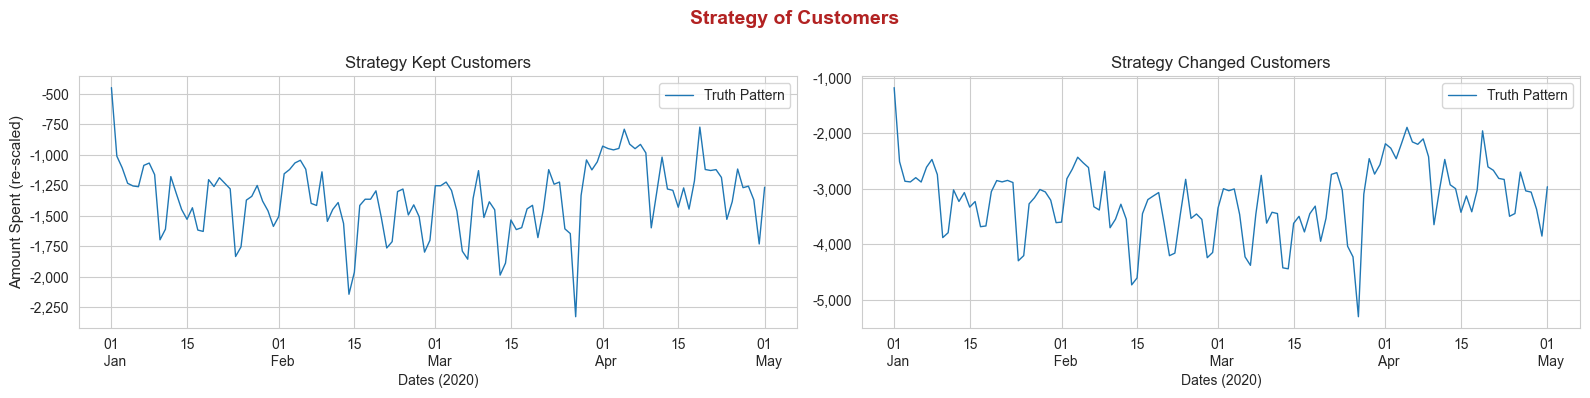

In [16]:
kept_clusters_portion = wdf_kept_clusters.loc[(wdf_kept_clusters.index >= '2020-01-01') & (wdf_kept_clusters.index <= '2020-05-01')]
changed_clusters_portion = wdf_changed_clusters.loc[(wdf_changed_clusters.index >= '2020-01-01') & (wdf_changed_clusters.index <= '2020-05-01')]


fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 4))
ax = ax.flat
for i in range(0, 2, 1):
    if i == 0:

        sns.lineplot(data=kept_clusters_portion, y=kept_clusters_portion['Amount_MinMax'], x=kept_clusters_portion.index, ci = None, palette=pal, linewidth=1, ax = ax[i], label = 'Truth Pattern')


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='', loc='best') 
        ax[i].set_title('Strategy Kept Customers')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Amount Spent (re-scaled)', fontsize=11) 

    else:
        sns.lineplot(data=changed_clusters_portion, y=changed_clusters_portion['Amount_MinMax'], x=changed_clusters_portion.index, ci = None, palette=pal, linewidth=1, ax = ax[i], label = 'Truth Pattern')

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='', loc='best')
        ax[i].set_title('Strategy Changed Customers')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')

            
fig.suptitle('Strategy of Customers', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Strategy_of_the_Customers.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

## 5.1 Specifying recent actual pattern, i.e. taking piece of real pattern from time series just before prediction point

 * recent actual pattern = a piece of real pattern from time series just before prediction point (a real known output which the model learns on this data), we can think that, this is actually our y_train


In [17]:
''' prediction point, where the model will kick off to predict '''
prediction_point = pd.datetime(2020, 3, 15)    
M = 360
''' need to specify recent actual pattern just before prediction point'''
recent_actual_pattern_range_k =    kept_clusters.loc[pd.date_range(prediction_point - pd.Timedelta(M, unit='h'), prediction_point - pd.Timedelta(24, unit='h'), freq='d')] 
recent_actual_pattern_range_c = changed_clusters.loc[pd.date_range(prediction_point - pd.Timedelta(M, unit='h'), prediction_point - pd.Timedelta(24, unit='h'), freq='d')] 

recent_actual_pattern_range_k

2020-02-29   -1701.6034
2020-03-01   -1253.7253
2020-03-02   -1253.6226
2020-03-03   -1223.5671
2020-03-04   -1292.5796
2020-03-05   -1462.5353
2020-03-06   -1790.3158
2020-03-07   -1856.4595
2020-03-08   -1357.7107
2020-03-09   -1129.7619
2020-03-10   -1514.1959
2020-03-11   -1385.3347
2020-03-12   -1451.3810
2020-03-13   -1987.1293
2020-03-14   -1888.3405
Name: Amount_MinMax, dtype: float64

## 5.2 Finding the most similar pattern, from the target time series, starting from begining till the prediction point 

*  to define the exact type of linear dependency, that is, linear relationship, we use Pearson correlation, because it is a methode for resemblance/similarity measuring of linearity


In [18]:
similarity_measure_k = []
time_delay_k = []
loop_range_k = pd.date_range(kept_clusters.index[0], prediction_point - pd.Timedelta(M + 24, unit='h'), freq='d')

similarity_measure_c = []
time_delay_c = []
loop_range_c = pd.date_range(changed_clusters.index[0], prediction_point - pd.Timedelta(M + 24, unit='h'), freq='d')

for i in loop_range_k:

    temp_range = pd.date_range(i, i + pd.Timedelta(M-24, unit='h'), freq='d')
    ds = kept_clusters.loc[temp_range].values
    time_delay_k.append(i)

    if np.sum(ds) == 0:
        similarity_measure_k.append(0)
    else:
        c = np.abs(np.corrcoef(ds, recent_actual_pattern_range_k.values))  # Similarity measure = abs of linear correlation
        similarity_measure_k.append(c[0, 1])


for i in loop_range_c:

    temp_range = pd.date_range(i, i + pd.Timedelta(M-24, unit='h'), freq='d')
    ds = changed_clusters.loc[temp_range].values
    time_delay_c.append(i)

    if np.sum(ds) == 0:
        similarity_measure_c.append(0)
    else:
        c = np.abs(np.corrcoef(ds, recent_actual_pattern_range_c.values))
        similarity_measure_c.append(c[0, 1])

In [19]:
''' discovering the pattern, which corresponds to maximum value of the most similar pattern '''

similarity_k = pd.DataFrame(similarity_measure_k, index=time_delay_k, columns=['similarity_k'])
most_similar_k = np.max(similarity_k.values)

similarity_c = pd.DataFrame(similarity_measure_c, index=time_delay_c, columns=['similarity_c'])
most_similar_c = np.max(similarity_c.values)

most_similar_k

0.8881445057934986

In [20]:
max_time_delay_k = similarity_k[similarity_k.values == most_similar_k].index
max_time_delay_c = similarity_c[similarity_c.values == most_similar_c].index

max_time_delay_k

DatetimeIndex(['2018-11-10'], dtype='datetime64[ns]', freq=None)

In [21]:
most_similar_pattern_range_k = pd.date_range(max_time_delay_k[0], max_time_delay_k[0] + pd.Timedelta(M - 24, unit='h'), freq='d')
most_similar_pattern_k = kept_clusters.loc[most_similar_pattern_range_k]

most_similar_pattern_range_c = pd.date_range(max_time_delay_c[0], max_time_delay_c[0] + pd.Timedelta(M - 24, unit='h'), freq='d')
most_similar_pattern_c = changed_clusters.loc[most_similar_pattern_range_c]

most_similar_pattern_k

2018-11-10   -1601.5040
2018-11-11   -1266.6180
2018-11-12   -1249.4642
2018-11-13   -1107.5211
2018-11-14   -1311.4706
2018-11-15   -1445.2616
2018-11-16   -1531.4420
2018-11-17   -1563.5203
2018-11-18   -1165.6661
2018-11-19   -1104.5826
2018-11-20   -1165.4640
2018-11-21   -1155.6111
2018-11-22   -1151.5752
2018-11-23   -1728.3138
2018-11-24   -1705.4006
Name: Amount_MinMax, dtype: float64

## 5.3 Establishing a linear relationship between the independent and dependent variables 

**ElasticNet**

* ElasticNet combines L1 norms (LASSO) and L2 norms (ridge regression) into a penalized model for generalized linear regression. This gives it sparsity (L1) and robustness (L2) properties.

In [22]:
model_k = LinearRegression()
x_train_k = np.column_stack((most_similar_pattern_k.values, np.ones(len(most_similar_pattern_k))))
model_k.fit(x_train_k, recent_actual_pattern_range_k.values)
most_similar_pattern_predicted_values_k = model_k.predict(x_train_k)  # our x_train = x_test


model_c = LinearRegression()
x_train_c = np.column_stack((most_similar_pattern_c.values, np.ones(len(most_similar_pattern_c))))
model_c.fit(x_train_c, recent_actual_pattern_range_c.values)
most_similar_pattern_predicted_values_c = model_c.predict(x_train_c)


most_similar_pattern_predicted_values_k

array([-1776.62372097, -1412.24436902, -1393.57980231, -1239.13581816,
       -1461.0470932 , -1606.62102119, -1700.39133046, -1735.29476437,
       -1302.40168077, -1235.93855874, -1302.18176599, -1291.46106848,
       -1287.06971588, -1914.6016239 , -1889.67047942])

## 5.4 Base pattern is a piece of time series, coming just after the most similar pattern

In [23]:
''' now, we need to define the base pattern which is actually the time series piece which comes right after the most similar pattern on the time axis '''

base_pattern_range_k = pd.date_range(most_similar_pattern_k.index[-1] + pd.Timedelta(24, unit='h'), most_similar_pattern_k.index[-1] + pd.Timedelta(M, unit='h'), freq='d')
base_pattern_k = kept_clusters.loc[base_pattern_range_k]

base_pattern_range_c = pd.date_range(most_similar_pattern_c.index[-1] + pd.Timedelta(24, unit='h'), most_similar_pattern_c.index[-1] + pd.Timedelta(M, unit='h'), freq='d')
base_pattern_c = changed_clusters.loc[base_pattern_range_c]

base_pattern_k


2018-11-25   -1374.6455
2018-11-26   -1246.4666
2018-11-27   -1175.5299
2018-11-28   -1213.6082
2018-11-29   -1212.6448
2018-11-30   -1460.4348
2018-12-01   -1442.5915
2018-12-02   -1107.7520
2018-12-03   -1017.6445
2018-12-04   -1042.6323
2018-12-05   -1001.5836
2018-12-06   -1090.6562
2018-12-07   -1373.4294
2018-12-08   -1463.5527
2018-12-09   -1065.6645
Name: Amount_MinMax, dtype: float64

## 5.5 Prediction pattern is calculated using the base pattern and obtained linear dependency

In [24]:
prediction_range_k = pd.date_range(recent_actual_pattern_range_k.index[-1] + pd.Timedelta(24, unit='h'), recent_actual_pattern_range_k.index[-1] + pd.Timedelta(M, unit='h'), freq='d')
x_k = np.column_stack((base_pattern_k.values, np.ones(len(base_pattern_k))))
y_k = model_k.predict(x_k) # x_k = x_test
predicted_values_k = pd.DataFrame(y_k, index=prediction_range_k, columns=['Amount_k'])


prediction_range_c = pd.date_range(recent_actual_pattern_range_c.index[-1] + pd.Timedelta(24, unit='h'), recent_actual_pattern_range_c.index[-1] + pd.Timedelta(M, unit='h'), freq='d')
x_c = np.column_stack((base_pattern_c.values, np.ones(len(base_pattern_c))))
y_c = model_c.predict(x_c)
predicted_values_c = pd.DataFrame(y_c, index=prediction_range_c, columns=['Amount_c'])

predicted_values_k

,Amount_k
2020-03-15,-1529.7858
2020-03-16,-1390.3183
2020-03-17,-1313.1341
2020-03-18,-1354.5659
2020-03-19,-1353.5178
2020-03-20,-1623.1305
2020-03-21,-1603.7158
2020-03-22,-1239.3870
2020-03-23,-1141.3438
2020-03-24,-1168.5323


In [25]:
kept_clusters_portion = wdf_kept_clusters.loc[(wdf_kept_clusters.index >= '2020-03-10') & (wdf_kept_clusters.index <= '2020-04-01')]
changed_clusters_portion = wdf_changed_clusters.loc[(wdf_changed_clusters.index >= '2020-03-10') & (wdf_changed_clusters.index <= '2020-04-01')]

most_similar_pattern_k = most_similar_pattern_k.to_frame()
recent_actual_pattern_range_k = recent_actual_pattern_range_k.to_frame()
base_pattern_k = base_pattern_k.to_frame()
most_similar_pattern_predicted_values_k = pd.DataFrame(most_similar_pattern_predicted_values_k, columns = ['Amount_MinMax'])

most_similar_pattern_c = most_similar_pattern_c.to_frame()
recent_actual_pattern_range_c = recent_actual_pattern_range_c.to_frame()
base_pattern_c = base_pattern_c.to_frame()
most_similar_pattern_predicted_values_c = pd.DataFrame(most_similar_pattern_predicted_values_c, columns = ['Amount_MinMax'])

In [26]:
next_pattern_after_pp_k = kept_clusters.loc[prediction_range_k]
next_pattern_after_pp_c = changed_clusters.loc[prediction_range_c]

MAE_k  = mean_absolute_error(next_pattern_after_pp_k.values, predicted_values_k.values)
MAPE_k = mean_absolute_percentage_error(next_pattern_after_pp_k.values, predicted_values_k.values) * 100
R2_k  = r2_score(next_pattern_after_pp_k.values, predicted_values_k.values)

MAE_c  = mean_absolute_error(next_pattern_after_pp_c.values, predicted_values_c.values)
MAPE_c = mean_absolute_percentage_error(next_pattern_after_pp_c.values, predicted_values_c.values) * 100
R2_c  = r2_score(next_pattern_after_pp_c.values, predicted_values_c.values)


Errors_k = 'MAE = %2.2f, MAPE = %2.2f %%' % (MAE_k, MAPE_k) # Errors_k = 'MAE = %2.2f, MAPE = %2.2f %% , R2 = %2.2f' % (MAE_k, MAPE_k, R2_k)
Errors_c = 'MAE = %2.2f, MAPE = %2.2f %%' % (MAE_c, MAPE_c)


Errors_k


'MAE = 219.72, MAPE = 13.73 %'

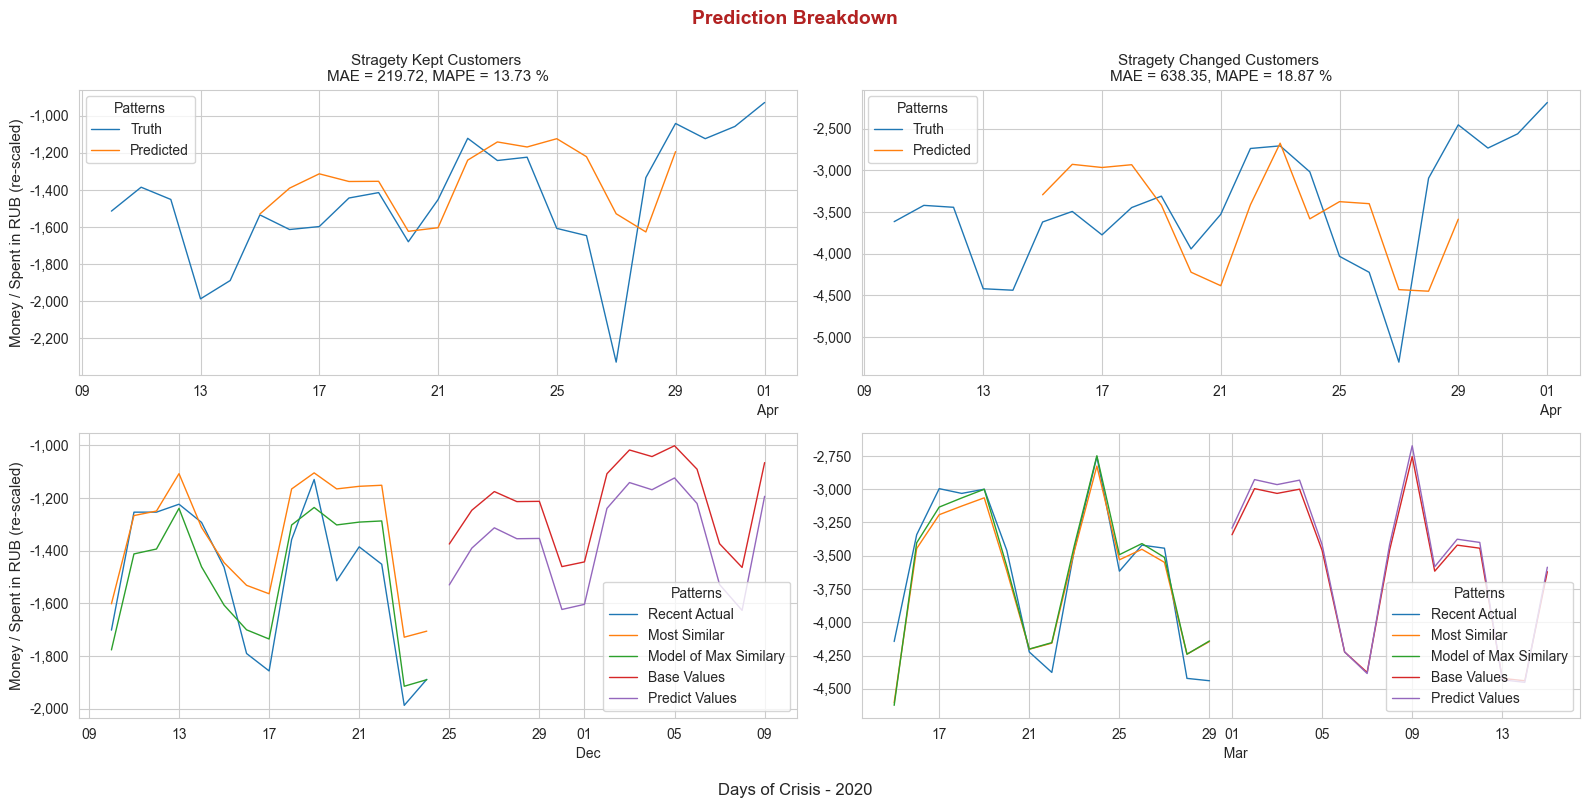

In [27]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
ax = ax.flat
for i in range(0, 4, 1):

    if i == 0:

        sns.lineplot(data=kept_clusters_portion, y=kept_clusters_portion['Amount_MinMax'], x=kept_clusters_portion.index, palette=pal, linewidth=1, ax = ax[i], label = 'Truth')
        sns.lineplot(data=predicted_values_k, y=predicted_values_k['Amount_k'], x=predicted_values_k.index, palette=pal, linewidth=1, ax = ax[i], label = 'Predicted')

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize = 6) 
        plt.setp(ax[i].get_legend().get_title(), fontsize = 10) 
        sns.move_legend(ax[i], title='Patterns', loc='best') 
        ax[i].set_title('Stragety Kept Customers \n' + Errors_k, fontsize = 11)
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Money / Spent in RUB (re-scaled)', fontsize=11) 

    elif i == 1:

        sns.lineplot(data=changed_clusters_portion, y=changed_clusters_portion['Amount_MinMax'], x=changed_clusters_portion.index, ci = None, palette=pal, linewidth=1, ax = ax[i], label = 'Truth')
        sns.lineplot(data=predicted_values_c, y=predicted_values_c['Amount_c'], x=predicted_values_c.index, ci = None, palette=pal, linewidth=1, ax = ax[i], label = 'Predicted')

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='10') 
        sns.move_legend(ax[i], title='Patterns', loc='best')
        ax[i].set_title('Stragety Changed Customers \n' + Errors_c, fontsize = 11)
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')

    elif i == 2:

        sns.lineplot(data=most_similar_pattern_k, y=recent_actual_pattern_range_k['Amount_MinMax'], x=most_similar_pattern_k.index, palette=pal, linewidth=1, ax = ax[i], label = 'Recent Actual')
        sns.lineplot(data=most_similar_pattern_k, y=most_similar_pattern_k['Amount_MinMax'], x=most_similar_pattern_k.index, palette=pal, linewidth=1, ax = ax[i], label = 'Most Similar')
        sns.lineplot(data=most_similar_pattern_k, y=most_similar_pattern_predicted_values_k['Amount_MinMax'], x=most_similar_pattern_k.index, palette=pal, linewidth=1, ax = ax[i], label = 'Model of Max Similary')
        sns.lineplot(data=base_pattern_k, y=base_pattern_k['Amount_MinMax'], x=base_pattern_k.index, palette=pal, linewidth=1, ax = ax[i], label = 'Base Values')
        sns.lineplot(data=base_pattern_k, y=predicted_values_k['Amount_k'], x=base_pattern_k.index, palette=pal, linewidth=1, ax = ax[i], label = 'Predict Values')


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='10') 
        sns.move_legend(ax[i], title='Patterns', loc='best')
        ax[i].set_title('')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Money / Spent in RUB (re-scaled)', fontsize=11) 


    else:

        sns.lineplot(data=most_similar_pattern_c, y=recent_actual_pattern_range_c['Amount_MinMax'], x=most_similar_pattern_c.index, ci = None, palette=pal, linewidth=1, ax = ax[i], label = 'Recent Actual')
        sns.lineplot(data=most_similar_pattern_c, y=most_similar_pattern_c['Amount_MinMax'], x=most_similar_pattern_c.index, ci = None, palette=pal, linewidth=1, ax = ax[i], label = 'Most Similar')
        sns.lineplot(data=most_similar_pattern_c, y=most_similar_pattern_predicted_values_c['Amount_MinMax'], x=most_similar_pattern_c.index, ci = None, palette=pal, linewidth=1, ax = ax[i], label = 'Model of Max Similary')
        sns.lineplot(data=base_pattern_c, y=base_pattern_c['Amount_MinMax'], x=base_pattern_c.index, ci = None, palette=pal, linewidth=1, ax = ax[i], label = 'Base Values')
        sns.lineplot(data=base_pattern_c, y=predicted_values_c['Amount_c'], x=base_pattern_c.index, ci = None, palette=pal, linewidth=1, ax = ax[i], label = 'Predict Values')


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='10') 
        sns.move_legend(ax[i], title='Patterns', loc='best')
        ax[i].set_title('')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')  


fig.suptitle('Prediction Breakdown', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
fig.supxlabel('Days of Crisis - 2020', fontsize = 12)
#plt.savefig('Forecast.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()